# Advanced Exercise Project 1: ANN Non Linear Regression

In this notebook, I built an artificial neural network to predict Blood Glucose Level (BGL) based on a range of physiological features. The dataset was relatively large (16,969 samples), and the features included vital signs like blood pressure, heart rate, body temperature, SPO2, and diabetes status.

In [ ]:
!pip install -q seaborn

### Step 0: Importing libraries and loading the dataset

### Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from tqdm.keras import TqdmCallback

### Step 0: Importing libraries and loading the dataset

In [ ]:
# STEP 1: Dataset
# 4 numeric cols, 1 continous target, logical trend

In [ ]:
folder_path = "/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_1"
os.chdir(folder_path)
data = pd.read_excel("data/blood_glucose.xlsx", skiprows=2)

In [ ]:
df = data.copy()
df.head()

,Age,Blood Glucose Level(BGL),Diastolic Blood Pressure,Systolic Blood Pressure,Heart Rate,Body Temperature,SPO2,Sweating (Y/N),Shivering (Y/N),Diabetic/NonDiabetic (D/N)
0,9,79,73,118,98,98.300707,99,0,0,N
1,9,80,73,119,102,98.300707,94,1,0,N
2,9,70,76,110,81,98.300707,98,1,0,N
3,9,70,78,115,96,98.300707,96,1,0,N
4,66,100,96,144,92,97.807052,98,0,0,N


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16969 entries, 0 to 16968
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         16969 non-null  int64  
 1   Blood Glucose Level(BGL)    16969 non-null  int64  
 2   Diastolic Blood Pressure    16969 non-null  int64  
 3   Systolic Blood Pressure     16969 non-null  int64  
 4   Heart Rate                  16969 non-null  int64  
 5   Body Temperature            16969 non-null  float64
 6   SPO2                        16969 non-null  int64  
 7   Sweating  (Y/N)             16969 non-null  int64  
 8   Shivering (Y/N)             16969 non-null  int64  
 9   Diabetic/NonDiabetic (D/N)  16969 non-null  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 1.3+ MB


In [ ]:
df.columns = df.columns.str.strip()

Here I had to convert the letters to numbers, in order to make the dataset fully numeric

In [ ]:
# Convert D/N to 0/1
df["Diabetic/NonDiabetic (D/N)"] = df["Diabetic/NonDiabetic (D/N)"].map({"D": 1, "N": 0})

In [ ]:
df['Blood Glucose Level(BGL)'].describe()

,Blood Glucose Level(BGL)
count,16969.000000
mean,95.731864
std,42.990652
min,50.000000
25%,68.000000
50%,83.000000
75%,108.000000
max,250.000000


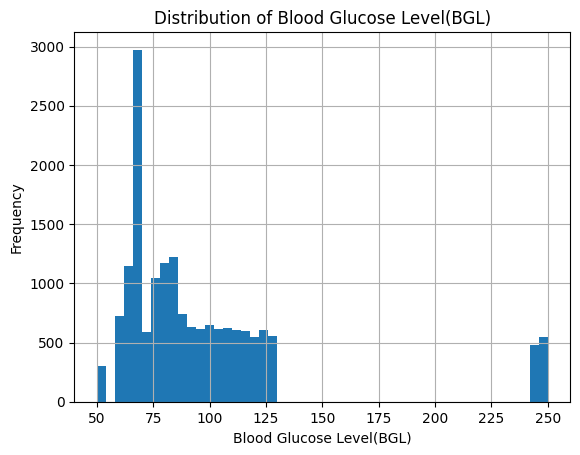

In [ ]:
df['Blood Glucose Level(BGL)'].hist(bins=50)
plt.xlabel('Blood Glucose Level(BGL)')
plt.ylabel('Frequency')
plt.title('Distribution of Blood Glucose Level(BGL)')
plt.show()

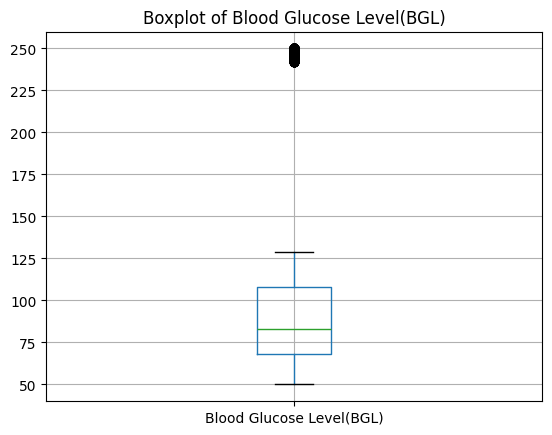

In [ ]:
df.boxplot(column='Blood Glucose Level(BGL)')
plt.title('Boxplot of Blood Glucose Level(BGL)')
plt.show()

In [ ]:
df['Blood Glucose Level(BGL)'].skew()

np.float64(2.4778336885474768)

### Step 2: Data pre-processing

In [ ]:
# STEP 2: Clean and Preprocess
# missing values, encode non-num cols, balance, visualisation

In [ ]:
# Drop rows where the target ('Life expectancy') is missing
df = df.dropna(subset=['Blood Glucose Level(BGL)'])

In [ ]:
# For the remaining missing numeric values, fill with the median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [ ]:
df.head()

,Age,Blood Glucose Level(BGL),Diastolic Blood Pressure,Systolic Blood Pressure,Heart Rate,Body Temperature,SPO2,Sweating (Y/N),Shivering (Y/N),Diabetic/NonDiabetic (D/N)
0,9,79,73,118,98,98.300707,99,0,0,0
1,9,80,73,119,102,98.300707,94,1,0,0
2,9,70,76,110,81,98.300707,98,1,0,0
3,9,70,78,115,96,98.300707,96,1,0,0
4,66,100,96,144,92,97.807052,98,0,0,0


In [ ]:
# STEP 3: Train/Test Split
# 70% 30% / 80% 20%

In [ ]:
# Define target and features
X = df.drop(columns=['Blood Glucose Level(BGL)'])
y = df['Blood Glucose Level(BGL)']

In [ ]:
# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (13575, 9)
Test set shape: (3394, 9)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Step 3: Model Architecture

The model was set to train for 100 epochs. The final training stopped early after 50 epochs.

In [ ]:
# STEP 4: ANN Model
# Dense Layers, input = features, output = 1

In [ ]:
# Get number of features for the input layer
input_dim = X_train_scaled.shape[1]  # Number of features
optimizer = keras.optimizers.Nadam(learning_rate=0.002)

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation="linear")
])

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# STEP 5: Fit Visualise
# Fit model
# Visualise (scatter plot), prediction distribution, trainaing loss / epochs

In [ ]:
# EXTRA TASK
early_stop = callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6)

In [ ]:
history = model.fit(X_train_scaled, y_train,
                    epochs=100,
                    batch_size=32,
                    callbacks=[(TqdmCallback(verbose=1, leave=False)),early_stop, reduce_lr],
                    verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

### Step 4: Model Evaluation

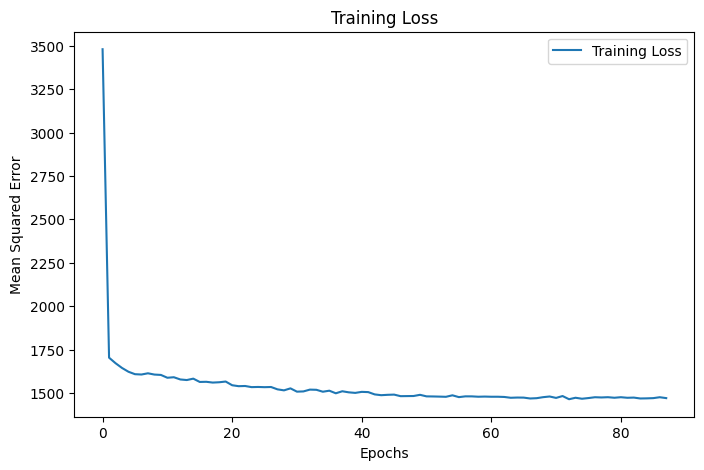

In [ ]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training Loss")
plt.legend()
plt.show()

In [ ]:
# STEP 6: Evaluate with metrics
# MAE, MSE, RMSE, R2, explained Variance Score

In [ ]:
# Predict on test set
y_pred = model.predict(X_test_scaled).flatten()

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
# Compute error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r2)
print("Explained Variance Score:", explained_var)

Mean Absolute Error (MAE): 20.90089988708496
Mean Squared Error (MSE): 1386.408935546875
Root Mean Squared Error (RMSE): 37.23451269382849
R-squared: 0.2113468050956726
Explained Variance Score: 0.2121926253400016


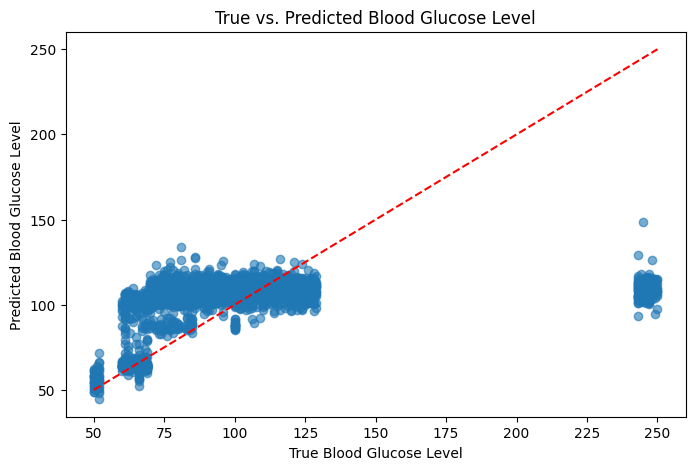

In [ ]:
# Scatter plot of true values vs. predictions
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("True Blood Glucose Level")
plt.ylabel("Predicted Blood Glucose Level")
plt.title("True vs. Predicted Blood Glucose Level")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

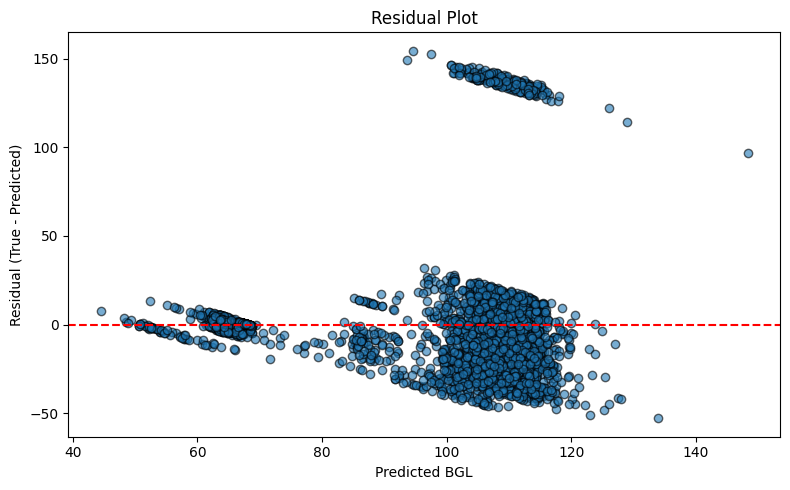

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted BGL")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

### Step 5: Predictions

In [ ]:
# STEP 7: Predict New Data
# imaginary input, correlation matrics, to identify key features

In [ ]:
# Create a new sample with your actual features
new_sample = pd.DataFrame({
    'Age': [25],
    'Diastolic Blood Pressure': [80],
    'Systolic Blood Pressure': [120],
    'Heart Rate': [85],
    'Body Temperature': [98.6],
    'SPO2': [97],
    'Sweating  (Y/N)': [1],
    'Shivering (Y/N)': [0],
    'Diabetic/NonDiabetic (D/N)': [1]
})

# Ensure column order matches training data exactly
new_sample = new_sample.reindex(columns=X.columns)

# Scale the new sample using the fitted scaler
new_sample_scaled = scaler.transform(new_sample)

# Predict using your trained model
new_prediction = model.predict(new_sample_scaled)
print("Predicted Blood Glucose Level:", new_prediction[0], "mg/dl")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Predicted Blood Glucose Level: [100.328964] mg/dl


### Personal Analysis / Refelection

In [ ]:
# STEP 8: Personal Analysis
# thoughts after every phase, code explaination, real life uses, challenges, ideas

In [ ]:
# Optional: Tkinter, PySimp

The first results suggested a weak predictive performance.


```
# 1st setup
model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='linear')  # Output layer for regression
])

```


The R² value of ~0.19 means that the model only explains 19% of the variance in blood glucose levels. The average prediction error (RMSE ~37 mg/dL) is quite high given that the glucose levels in the dataset typically range between 50–250 mg/dL. While the model learned something, it clearly struggled to capture the non-linear relationships in the data.


The second results showed a little bit of improvement after adding Batch Normalization and Dropout



```
# 2nd setup
model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation="linear")
])
```

The R² value improved by 0.02, so the modifications only helped a little. My assumption is that blood glucose prediction is inherently hard using general vitals. If key predictors (like insulin, carbs, physical activity, timestamps) are missing, even the best model won't perform well.


### EXTRA: Predictions with a simple GUI

I also implemented a basic UI in this non linear ANN exercise using ipywidgets to input new feature values and get an instant prediction. As an extra I added 3 sliders for binary values.

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# layout and style
common_layout = widgets.Layout(width='400px')
common_style = {'description_width': '180px'}

# widgets for all input features
age_widget = widgets.IntText(value=25, description='Age:', layout=common_layout, style=common_style)
diastolic_bp_widget = widgets.IntText(value=80, description='Diastolic BP:', layout=common_layout, style=common_style)
systolic_bp_widget = widgets.IntText(value=120, description='Systolic BP:', layout=common_layout, style=common_style)
heart_rate_widget = widgets.IntText(value=85, description='Heart Rate:', layout=common_layout, style=common_style)
body_temp_widget = widgets.FloatText(value=98.6, description='Body Temp (°F):', layout=common_layout, style=common_style)
spo2_widget = widgets.IntText(value=97, description='SPO2 (%):', layout=common_layout, style=common_style)
sweating_widget = widgets.IntSlider(value=1, min=0, max=1, step=1, description='Sweating (0/1):', layout=common_layout, style=common_style)
shivering_widget = widgets.IntSlider(value=0, min=0, max=1, step=1, description='Shivering (0/1):', layout=common_layout, style=common_style)
diabetic_status_widget = widgets.IntSlider(value=1, min=0, max=1, step=1, description='Diabetic (1) / Non (0):', layout=common_layout, style=common_style)

# Prediction button and output display
predict_button = widgets.Button(description='Predict Blood Glucose Level', layout=common_layout)
output = widgets.Output()

# prediction logic
def predict_bgl(b):
    with output:
        output.clear_output()

        # input DataFrame
        new_sample = pd.DataFrame({
            'Age': [age_widget.value],
            'Diastolic Blood Pressure': [diastolic_bp_widget.value],
            'Systolic Blood Pressure': [systolic_bp_widget.value],
            'Heart Rate': [heart_rate_widget.value],
            'Body Temperature': [body_temp_widget.value],
            'SPO2': [spo2_widget.value],
            'Sweating  (Y/N)': [sweating_widget.value],
            'Shivering (Y/N)': [shivering_widget.value],
            'Diabetic/NonDiabetic (D/N)': [diabetic_status_widget.value]
        })

        # Ensure columns are in the correct order
        new_sample = new_sample.reindex(columns=X.columns)

        # Scale using fitted scaler
        new_sample_scaled = scaler.transform(new_sample)

        # Predict using trained model
        prediction = model.predict(new_sample_scaled)
        print("Predicted Blood Glucose Level:", round(float(prediction[0].item()), 2), "mg/dl")

# Connect the button
predict_button.on_click(predict_bgl)

# UI
widget_box = widgets.VBox([
    age_widget,
    diastolic_bp_widget,
    systolic_bp_widget,
    heart_rate_widget,
    body_temp_widget,
    spo2_widget,
    sweating_widget,
    shivering_widget,
    diabetic_status_widget,
    predict_button,
    output
])

display(widget_box)

### EXTRA: Linear regression with scikit-learn

In [ ]:
# Advanced Task:
# 1 Compare with Linear Regression using scikit-learn
# 1 Try same model on linear and non-linear datasets
# 1 Compare performance

# 2 Use Dropout layers, EarlyStopping, ReduceLRONPLateau

In [ ]:
# EXTRA TASK: Linear Regression using scikit-learn

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Train the non-linear model
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_scaled, y_train)
y_pred_rf = rf_reg.predict(X_test_scaled)

# Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
explained_var_rf = explained_variance_score(y_test, y_pred_rf)

# Print results
print("\nNon-Linear Regression Model (Random Forest) Evaluation:")
print("Mean Absolute Error (MAE):", mae_rf)
print("Mean Squared Error (MSE):", mse_rf)
print("Root Mean Squared Error (RMSE):", rmse_rf)
print("R-squared:", r2_rf)
print("Explained Variance Score:", explained_var_rf)


Non-Linear Regression Model (Random Forest) Evaluation:
Mean Absolute Error (MAE): 21.36575541938738
Mean Squared Error (MSE): 1451.9760673724002
Root Mean Squared Error (RMSE): 38.10480373092611
R-squared: 0.17404923730507482
Explained Variance Score: 0.1786149543824862


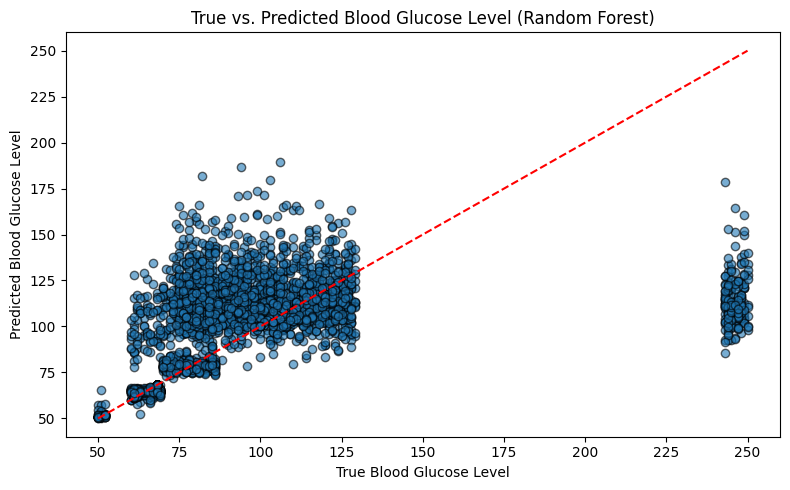

In [ ]:
# Plot true vs predicted
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_rf, alpha=0.6, edgecolors='k')
plt.xlabel("True Blood Glucose Level")
plt.ylabel("Predicted Blood Glucose Level")
plt.title("True vs. Predicted Blood Glucose Level (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()